# Data processing 
This notebook is intended to work through the whole data processing
pipeline, making all the corrections to the observed travel times such
that we can try to invert for CMB topography. We'll need access to all
the tools, so do something like this before starting:

    export PYTHONPATH="../tools:../:../tools/packages/lib/python/:../tools/tomocorr"
    
(and make sure you can run the other notebooks

In [1]:
# Environment setup - quite a lot here

# Make pictures show up in the web browser,
# import matplotlib etc, and make the figures
# big
%matplotlib inline
import matplotlib 
import matplotlib.pyplot as plt
import mpl_toolkits.basemap as basemap
plt.rcParams['figure.figsize'] = (12, 8)

# Other "standard" modules
import pandas
import numpy as np

# Get access to taup
import obspy.taup

# Geodesic calculations
import geographiclib.geodesic as geod

# Our ISC parser
import read_ISC

# tomographic correction
import tomocorr2

# Our ellipticity corrections
import ellippy

## Read and plot data
Here we read in the EQ data and load it into
a Pandas dataframe. We then calculate travel
times and store these in seconds (not deltatime
objects).

In [2]:
all_picks = read_ISC.read_picks('../data/ISC_Jan_2012_trim.dat', ('P', 'PcP'))
paired_picks = read_ISC.pair_picks(all_picks, 'PcP', 'P')

# Put in a dataframe
paired_picks_df = pandas.DataFrame.from_dict(paired_picks, orient='index')

# Remove Pdiff
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance < 80)]

# Remove P triplications
paired_picks_df = paired_picks_df[(paired_picks_df.epicentral_distance > 30)]

# Calculate PcP and P travel time (and store as a real in seconds)
paired_picks_df["PcP_ttime"] = (paired_picks_df.PcP_datetime - 
                                paired_picks_df.event_datetime).values / np.timedelta64(1, 's')
paired_picks_df["P_ttime"] = (paired_picks_df.P_datetime - 
                              paired_picks_df.event_datetime).values / np.timedelta64(1, 's')


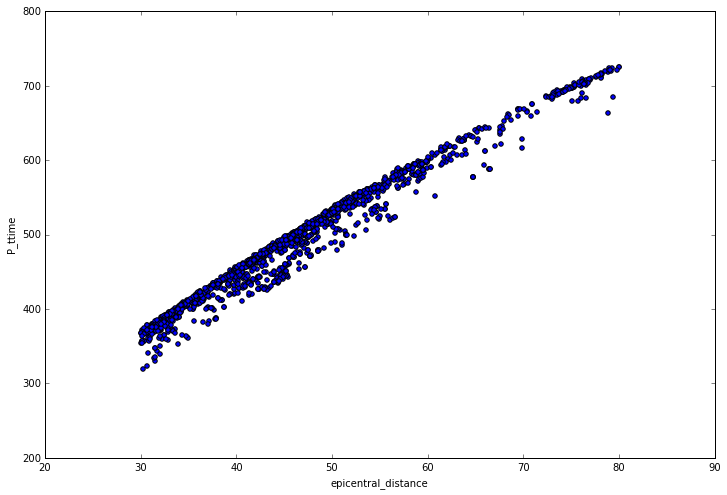

In [3]:
# Plot P travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='P_ttime')

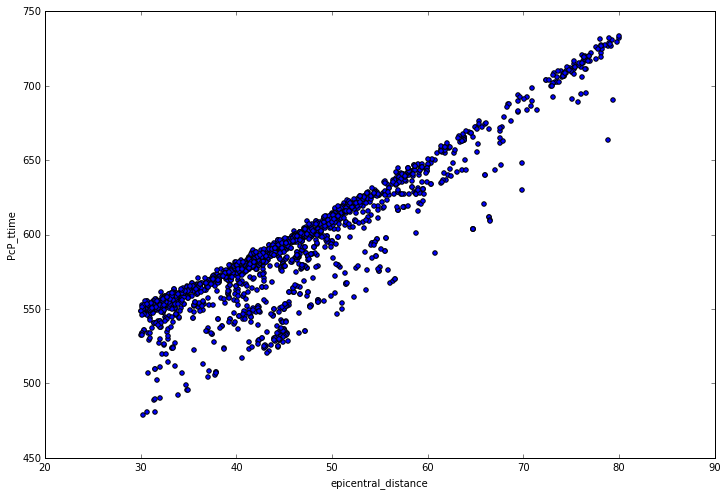

In [4]:
# Plot PcP travel times
paired_picks_df.plot(kind='scatter', x='epicentral_distance', y='PcP_ttime')

## Bounce points on the CMB
We'll use a 1D model to work out the bounce points for
PcP on the CMB and add these to the dataframe. We can
then use these to plot data geographically.

In [7]:
# We need a taup model that knows about 
# location. We've got one of these (it's
# a subclass of obspy.tau) and it lives
# in our tomography correction code for
# now. We'll assume a spherical Earth 
# (see below for the correction for
# this).
taup_model = tomocorr2.TauPyModelGeo(model="iasp91", 
                                     ellipsoid=geod.Geodesic(a=6371000.0, f=0))

# Function to find the bounce point
def calc_bounce_point_lat(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lat = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lat']
    return lat[0]

def calc_bounce_point_lon(source_depth, source_lat, source_lon, station_lat, station_lon):
    arrivals = taup_model.get_pierce_points_geo(source_depth, source_lat, source_lon,
                                                station_lat, station_lon, ['PcP'])
    # Our list of arrivals should always have just one arrival (for PcP)
    # so we will use this, and extract the lat and lon at the CMB depth
    lon = arrivals[0].pierce[arrivals[0].pierce['depth'] == 2889.0]['lon']
    return lon[0]

paired_picks_df['CMB_bounce_lat'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lat(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)
  
paired_picks_df['CMB_bounce_lon'] = paired_picks_df.apply(
    lambda row: calc_bounce_point_lon(row['event_depth'], 
                                      row['event_lat'],
                                      row['event_lon'], 
                                      row['station_lat'],
                                      row['station_lon']), axis=1)

In [8]:
paired_picks_df
    

,eventid,P_datetime,station_lon,reporter,PcP_datetime,epicentral_distance,station_elev,event_lat,station,backazimuth,event_depth,event_lon,event_datetime,station_lat,PcP_ttime,P_ttime,CMB_bounce_lat,CMB_bounce_lon
600130102GTABJI,600130102,2012-01-01 00:38:39.200,99.8144,BJI,2012-01-01 00:40:10.900,47.42,1341.0,11.9775,GTA,313.2,27.5,143.7081,2012-01-01 00:30:07.200,39.4106,603.70,512.00,27.376471,124.492437
600130102GYABJI,600130102,2012-01-01 00:37:21.200,106.6640,BJI,2012-01-01 00:39:38.700,37.67,1162.0,11.9775,GYA,297.9,27.5,143.7081,2012-01-01 00:30:07.200,26.4586,571.50,434.00,20.174856,126.056552
600130102KLRIDC,600130102,2012-01-01 00:37:25.400,131.7500,IDC,2012-01-01 00:39:39.170,38.44,298.0,11.9775,KLR,347.4,27.5,143.7081,2012-01-01 00:30:07.200,49.2300,571.97,438.20,30.714847,138.931294
600130102KSHBJI,600130102,2012-01-01 00:40:50.000,75.9731,BJI,2012-01-01 00:41:23.300,65.33,1314.0,11.9775,KSH,308.0,27.5,143.7081,2012-01-01 00:30:07.200,39.5167,676.10,642.80,30.058319,114.405047
600130102PETKIDC,600130102,2012-01-01 00:38:00.270,157.6989,IDC,2012-01-01 00:39:51.750,42.53,400.0,11.9775,PETK,12.5,27.5,143.7081,2012-01-01 00:30:07.200,53.1082,584.55,473.07,32.704046,149.014087
600130102SONMIDC,600130102,2012-01-01 00:38:39.360,106.3950,IDC,2012-01-01 00:40:09.380,47.41,1415.8,11.9775,SONM,326.3,27.5,143.7081,2012-01-01 00:30:07.200,47.8347,602.18,512.16,31.191645,128.664731
600130102ZALVIDC,600130102,2012-01-01 00:40:26.100,84.8188,IDC,2012-01-01 00:41:05.750,62.28,229.4,11.9775,ZALV,325.1,27.5,143.7081,2012-01-01 00:30:07.200,53.9481,658.55,618.90,36.386404,122.280212
600130103AS01NEIC,600130103,2012-01-01 00:56:35.790,133.9510,NEIC,2012-01-01 00:59:19.090,33.03,605.0,-11.3505,AS01,243.9,37.0,166.2200,2012-01-01 00:50:04.840,-23.6647,554.25,390.95,-18.168255,150.675255
600130103ASARIDC,600130103,2012-01-01 00:56:36.100,133.9040,IDC,2012-01-01 00:59:19.400,33.07,607.0,-11.3505,ASAR,243.9,37.0,166.2200,2012-01-01 00:50:04.840,-23.6664,554.56,391.26,-18.171148,150.652760
600130103STKAIDC,600130103,2012-01-01 00:56:15.400,141.5952,IDC,2012-01-01 00:59:13.370,30.55,272.3,-11.3505,STKA,224.2,37.0,166.2200,2012-01-01 00:50:04.840,-31.8769,548.53,370.56,-22.054846,154.824393
